# Data Augmentation

Combine different samples in the dataset by using various "layering" techniques.

## 1. Imports

In [1]:
import os
import sys
sys.path.append('quality')

from librosa.effects import trim
from librosa.util import normalize
from soundfile import write
import matplotlib.pyplot as plt
import numpy as np

from quality.filters import butter_lp, butter_hp
from quality.qual import kick_qual

import torch
from torchaudio import load

datapath = "../sampleset/full"
target = "../sampleset/augm"

Fs = 44100

def load_sample(path):
    sample = load(datapath + "/" + path)[0][0].numpy()
    return normalize(butter_hp(trim(sample, top_db=50)[0],10))

def save_sample(sample, path):
    write(target + "/" + path, sample, Fs)

C:\Users\damen\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\damen\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
dataset = []
for f in os.listdir(datapath):
    dataset.append(load_sample(f))
print(len(dataset))

456


## 2. Basic lowpass/highpass layering

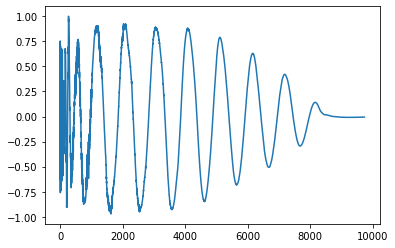

In [3]:
def layer_lowhigh(sample1, sample2,freq=400):
    lp = butter_lp(sample1, freq, order=3)
    hp = butter_hp(sample2, freq, order=4)
    n = max(len(lp), len(hp))
    out = np.empty(n)
    for i in range(0,min(len(lp), len(hp))):
        out[i] = lp[i] + hp[i]
    for i in range(min(len(lp), len(hp)), n):
        if i >= len(lp):
            out[i] = hp[i]
        else:
            out[i] = lp[i]
    return normalize(out)

def layer_stupid(sample1, sample2,freq=400):
    lp = sample1
    hp = sample2
    n = max(len(lp), len(hp))
    out = np.empty(n)
    for i in range(0,min(len(lp), len(hp))):
        out[i] = lp[i] + hp[i]
    for i in range(min(len(lp), len(hp)), n):
        if i >= len(lp):
            out[i] = hp[i]
        else:
            out[i] = lp[i]
    return normalize(out)


plt.plot(layer_lowhigh(dataset[5], dataset[210]))
plt.show()

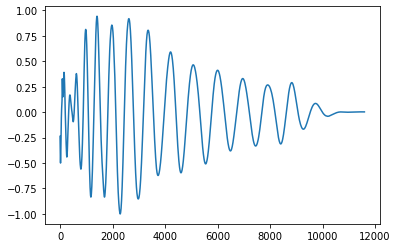

In [4]:
import IPython
import tikzplotlib

def display(sample):
    #do some pre and post padding to make the playback more smooth:
    out = np.empty(len(sample) + 4000)
    for i in range(0,2000):
        out[i] = 0.0
    for i in range(0,len(sample)):
        out[1000+i] = sample[i]
    for i in range(len(sample),len(sample)+2000):
        out[i] = 0.0
    return IPython.display.Audio(sample,rate=Fs)

l_a = 119
plt.plot(dataset[l_a][100:])
tikzplotlib.clean_figure(target_resolution=400)
tikzplotlib.save('layer0.tex', axis_width='3.52in', axis_height='2.64in')
plt.show()
display(dataset[l_a][100:])

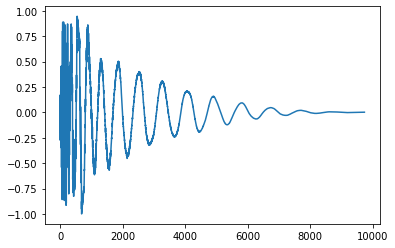

In [5]:
l_b = 354
plt.plot(dataset[l_b])
tikzplotlib.clean_figure(target_resolution=400)
tikzplotlib.save('layer1.tex', axis_width='3.52in', axis_height='2.64in')
plt.show()
display(dataset[l_b])

Combining 119 and 354:
1.0035709218138689
0.7526805300747899
0.6648373382813617


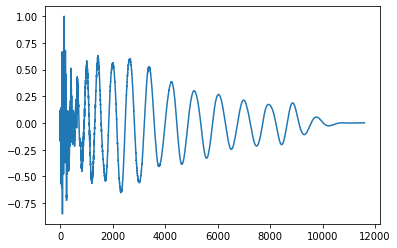

In [6]:
print(f"Combining {l_a} and {l_b}:")
print(kick_qual(dataset[l_a][100:]))
print(kick_qual(dataset[l_b]))
print(kick_qual(layer_lowhigh(dataset[l_a][100:], dataset[l_b])))
plt.plot(layer_lowhigh(dataset[l_a][100:], dataset[l_b]))
tikzplotlib.clean_figure(target_resolution=400)
tikzplotlib.save('layer2.tex', axis_width='3.52in', axis_height='2.64in')
plt.show()
display(layer_lowhigh(dataset[l_a][100:], dataset[l_b]))

0.6109859540905134


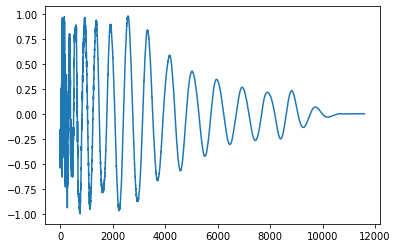

In [7]:
print(kick_qual(layer_stupid(dataset[l_a][100:], dataset[l_b])))
plt.plot(layer_stupid(dataset[l_a][100:], dataset[l_b]))
plt.show()
display(layer_stupid(dataset[l_a][100:], dataset[l_b]))

**The new combined sample is better than the original two samples!**
Which is precisely the goal: We have combined a sample with a defined high end with a sample with a good decay

### 2.1. Running the cartesian product
We combine the samples with the highest frequency response score with the samples with the highest decay score.

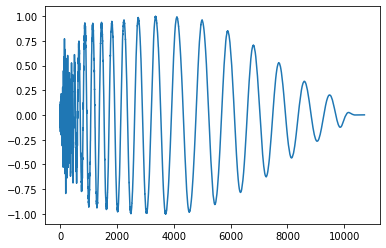

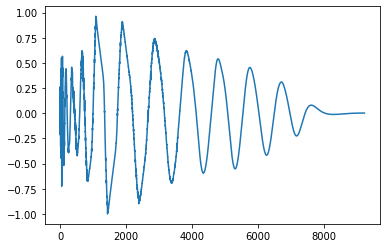

In [8]:
from quality.decay import env_qual, rms_qual
from quality.tonality import frq_qual, ihd_qual
from quality.response import res_qual

top_low = []
top_high = []

def sort_low(sample):
    return 20 * env_qual(sample) + rms_qual(sample) + frq_qual(sample)

def sort_high(sample):
    return res_qual(sample) + ihd_qual(sample)

dataset.sort(key=sort_low)
top_low = dataset[0:200]
dataset.sort(key=sort_high)
top_high = dataset[0:200]

plt.plot(top_low[2])
plt.show()
plt.plot(top_high[3])
plt.show()

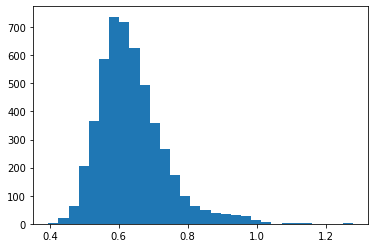

In [9]:
import itertools

lyqs = []

ex_samples = []

i_t = 0
for i in range(len(top_low)):
    for j in range(i % 8, len(top_high), 8):
        sample = layer_lowhigh(top_low[i], top_high[j], freq=375+5*(i % 7 + j % 5))
        q = kick_qual(sample)
        if q <= 1.5:
            lyqs.append(q)
            ex_samples.append(sample)

plt.rcParams['hist.bins'] = 30
plt.hist(lyqs)
plt.show()

In [16]:
print(np.mean(lyqs))
print(np.min(lyqs))
print(np.max(lyqs))

0.6378186845983439
0.39570301421499654
1.2786850730342232


In [239]:
i_b = 0

0.6818050669637226


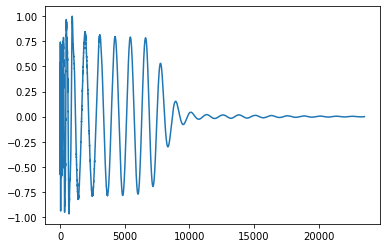

In [283]:
i_b = i_b+47 % len(ex_samples)
print(kick_qual(ex_samples[i_b]))
plt.plot(ex_samples[i_b])
plt.show()
display(ex_samples[i_b])

In [168]:
print(rms_qual(ex_samples[i_b]))

0.6578560683315595


In [15]:
print(len(ex_samples))

4999


In [12]:
augm_quals = []

for f in os.listdir(target):
    sample = load(target + "/" + f)[0][0].numpy()
    augm_quals.append(kick_qual(sample))
    

quality\decay.py:12: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k * (x - x0)))


In [28]:
augm_quals_filtered = []
orig_quals = []
for i, f in enumerate(os.listdir(target)):
    if f.startswith("augm"):
        if augm_quals[i] <= 1.5:
            augm_quals_filtered.append(augm_quals[i])
            continue
    else:
        if(augm_quals[i] > 1.6):
            print(f)
        orig_quals.append(augm_quals[i])

orig_125.wav
orig_403.wav
orig_58.wav
orig_63.wav


In [29]:
print(len(orig_quals))
print(np.mean(orig_quals))
print(np.min(orig_quals))
print(np.max(orig_quals))

456
0.758287216988075
0.4545333941384405
1.9569718370845455


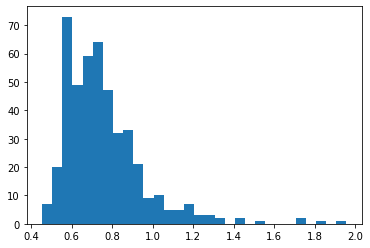

In [27]:
plt.hist(orig_quals)
plt.show()

In [21]:
print(len(augm_quals_filtered))
print(np.mean(augm_quals_filtered))
print(np.min(augm_quals_filtered))
print(np.max(augm_quals_filtered))

6497
0.6497331978495597
0.4278399673455518
1.4200658548138043


In [19]:
len(augm_quals)

6954

In [5]:
m1_q = []
for f in os.listdir('m1'):
    s = load(f'm1/{f}')[0][0].numpy()
    m1_q.append(kick_qual(s))

In [11]:
print(np.mean(m1_q))
print(np.max(m1_q))
print(np.min(m1_q))

0.917666012755614
2.0026941492730286
0.5811325018641917


In [12]:
m2_q = []
for f in os.listdir('m2'):
    s = load(f'm2/{f}')[0][0].numpy()
    m2_q.append(kick_qual(s))
print(np.mean(m2_q))
print(np.max(m2_q))
print(np.min(m2_q))

0.7016751196280764
2.601838433674504
0.4709287542406327


In [13]:
m3_q = []
for f in os.listdir('m3'):
    s = load(f'm3/{f}')[0][0].numpy()
    m3_q.append(kick_qual(s))
print(np.mean(m3_q))
print(np.max(m3_q))
print(np.min(m3_q))

1.122445021550177
2.9194531566830983
0.6837298542461651


In [14]:
d1_q = []
for f in os.listdir('d1'):
    s = load(f'd1/{f}')[0][0].numpy()
    d1_q.append(kick_qual(s))
print(np.mean(d1_q))
print(np.max(d1_q))
print(np.min(d1_q))

0.7449801954328796
1.682424557806606
0.4352790466665235


In [15]:
d2_q = []
for f in os.listdir('d2'):
    s = load(f'd2/{f}')[0][0].numpy()
    d2_q.append(kick_qual(s))
print(np.mean(d2_q))
print(np.max(d2_q))
print(np.min(d2_q))

0.550452235656086
0.8580725242361192
0.43211939841217156


In [16]:
d3_q = []
for f in os.listdir('d3'):
    s = load(f'd1/{f}')[0][0].numpy()
    d3_q.append(kick_qual(s))
print(np.mean(d3_q))
print(np.max(d3_q))
print(np.min(d3_q))

0.6904362800260168
1.07344682702133
0.45407215906586873


In [18]:
json_quals = {
    "m1": m1_q,
    "m2": m2_q,
    "m3": m3_q,
    "d1": d1_q,
    "d2": d2_q,
    "d3": d3_q
}

In [21]:
import json
with open("quals.json", "w") as f:
    json.dump(json_quals, f, indent=4)

In [3]:
m6_q = []
for f in os.listdir('samples/m5'):
    s = load(f'samples/m5/{f}')[0][0].numpy()
    m6_q.append(kick_qual(s))
print(np.mean(m6_q))
print(np.max(m6_q))
print(np.min(m6_q))
print(np.std(m6_q))

0.6886411078313324
1.5665917172170132
0.49315828516891885
0.15470282033569252


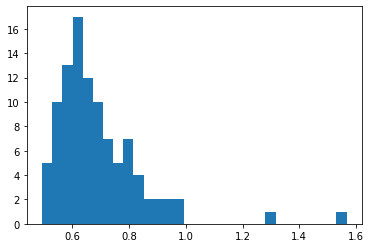

In [4]:
plt.rcParams['hist.bins'] = 30
plt.hist(m6_q)
plt.show()

In [6]:
import json
with open("quals.json", "r") as f:
    json_q = json.load(f)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)